# Описание проекта

### Задача

Задача – построить наиболее эффективную модель кредитного скоринга для вторичных клиентов банка.

Для решения задачи понадобится пройти следующие этапы:
1. Первичный анализ данных
2. Первичная обработка данных
3. Наивная модель
4. Вторичная обработка данных
5. Анализ значимости признаков
6. Логистическая регрессия
7. Подбор гиперпараметров
8. Прочие модели

### Описания полей

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

RANDOM_SEED = 31

# Вспомогательные функции

In [2]:
def visualise_metrics(model, X, y):
    # разделение выборки на train и valid
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=RANDOM_SEED, test_size=0.2)

    # Обучение модели на тренировочных данных и получение предсказания на валидационных
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    # вывод типа модели
    print()
    print('Model Type: ' + str(model))
    print()

    # вывод confusion matrix:
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True\nPositive', 'False\nPositive',
                   'False\nNegative', 'True\nNegative']
    group_counts = ['{0:0.0f}'.format(
        value) for value in confusion_matrix(y_valid, y_pred).flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_valid, y_pred),
                     annot=labels, fmt='', cmap='Reds')
    ax.set(xlabel='predicted', ylabel='real', title='Confusion Matrix')
    plt.show()
    print()

    # вывод значений метрик:
    print('accuracy_score:\t\t {:.3}'.format(accuracy_score(y_valid, y_pred)))
    print('f1_score:\t\t {:.3}'.format(f1_score(y_valid, y_pred)))
    print('recall_score:\t\t {:.3}'.format(recall_score(y_valid, y_pred)))
    print('MSE:\t\t\t {:.3}'.format(mean_squared_error(y_valid, y_pred)))
    print('roc_auc_score:\t\t {:.3}'.format(roc_auc_score(y_valid, probs)))
    print()


def test_all_models(X, y):
    # инициирование моделей
    lr = LogisticRegression(max_iter=1000)
    lr_balanced = LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
    dec_tree = DecisionTreeClassifier()
    extra_tree = ExtraTreeClassifier()
    ada_boost = AdaBoostClassifier()
    bagging = BaggingClassifier()
    extra_trees = ExtraTreesClassifier()
    grad_boost = GradientBoostingClassifier()
    rand_forest = RandomForestClassifier()
    cat_boost = CatBoostClassifier(silent=True)

    models = [
        lr,
        lr_balanced,
        dec_tree,
        extra_tree,
        ada_boost,
        bagging,
        extra_trees,
        grad_boost,
        rand_forest,
        cat_boost
    ]

    # прогон всех моделей и вывод результатов их работы
    for model in models:
        visualise_metrics(model, X, y)
        print('----------------------')

# Загрузка данных

In [3]:
data_dir = './kaggle/'

train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
sample = pd.read_csv(data_dir + 'sample_submission.csv')


# score = pd.read_csv('./kaggle/train.csv')

# 1. Первичный анализ данных

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

+ Видно, что пропуски есть только в информации об образовании клиентов - в колонке education. Надо будет заполнить эти пропуски.

In [6]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [7]:
sample.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [8]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [9]:
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

+ Данных об одном классе из целевой переменной значительно больше, чем о втором, этот дисбаланс надо будет иметь в виду. 

In [10]:
train.foreign_passport.value_counts()

N    62733
Y    11066
Name: foreign_passport, dtype: int64

+ Бинарная переменная.

In [11]:
train.first_time.value_counts()

3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64

+ "Давность наличия информации о заемщике". Непонятная переменная, но как будто бы между значениями есть отношение порядка.

In [12]:
train.sna.value_counts()

1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64

+ "Связь заемщика с клиентами банка". Опять что-то непонятное, то ли категориальная переменная, то ли числовая.

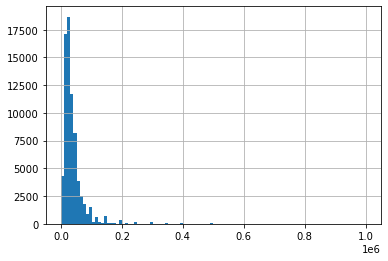

In [13]:
train.income.hist(bins=100)

+ Числовая переменная, длинный хвост из выбросов, надо будет нормализовывать.

In [14]:
train.work_address.value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

+ Категориальная переменная.

In [15]:
train.home_address.value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

+ Категориальная переменная.

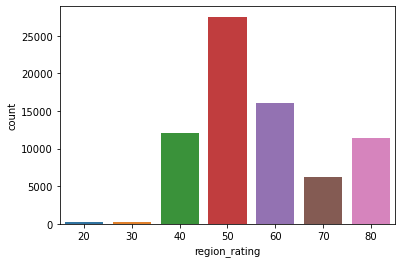

In [16]:
sns.countplot(x='region_rating', data=train)

+ "Рейтинг региона". Числовая переменная, которую можно было бы определить и к категориальным.

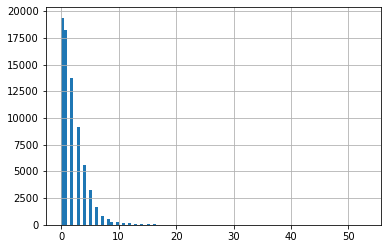

In [17]:
train.bki_request_cnt.hist(bins=100)

+ Числовая переменная, длинный хвост из выбросов, надо будет нормализовывать.

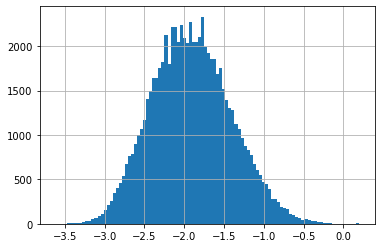

In [18]:
train.score_bki.hist(bins=100)

+ "Скоринговый балл по данным из БКИ". Числовая переменная, нормальное распределение с центром в районе -2. Странно. Видимо, этот признак уже предобрабатывался.

In [19]:
train.good_work.value_counts()

0    61630
1    12169
Name: good_work, dtype: int64

+ Бинарная переменная.

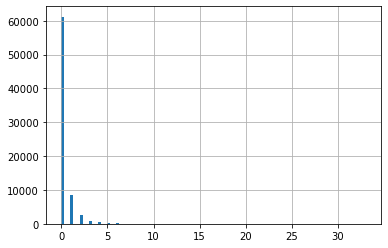

In [20]:
train.decline_app_cnt.hist(bins=100)

+ Числовая переменная, опять длинный хвост справа.

In [21]:
train.car_type.value_counts()

N    59791
Y    14008
Name: car_type, dtype: int64

+ Бинарная переменная.

In [22]:
train.car.value_counts()

N    49832
Y    23967
Name: car, dtype: int64

+ Бинарная переменная.

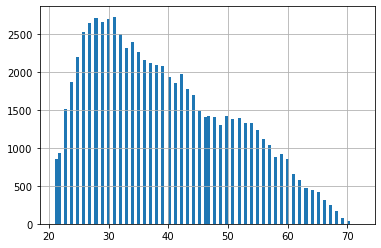

In [23]:
train.age.hist(bins=100)

+ Числовая переменная.

In [24]:
train.sex.value_counts()

F    41562
M    32237
Name: sex, dtype: int64

+ Бинарная переменная.

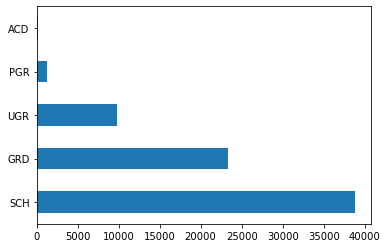

In [25]:
train.education.value_counts().plot.barh()

+ Категориальная переменная.

In [26]:
train.app_date.value_counts()

18MAR2014    1018
17MAR2014     911
19MAR2014     909
31MAR2014     904
07APR2014     882
             ... 
20APR2014     243
07JAN2014     228
03JAN2014     193
02JAN2014     137
01JAN2014      43
Name: app_date, Length: 120, dtype: int64

+ Потенциальный источник нескольких новых переменных: день недели, время года, давность заявки, etc.

In [27]:
len(train.client_id.unique())

73799

+ В идентификаторах нет дублей. Техническая переменная, которая не будет участвовать в обучении, но потребуется для формирования результата.

In [28]:
# для дальнейшей работы разделим переменные по типу

# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time']

# кроме идентификаторов и целевой переменной, остаётся ещё колонка app_date, которую можно будет подключить на этапе EDA

# 2. Первичная обработка данных

In [29]:
# для корректной обработки признаков объединяем train и test в один датасет

train['sample'] = 1   # помечаем тренировочные данные
test['sample'] = 0    # помечаем тестовые данные
# в тестовых данных отсутствуют значения default, поэтому пока заполняем константой
test['default'] = -1

score = pd.concat([train, test], ignore_index=True)

# посмотрим на колонки датасета, получившегося после объединения:
# признак | количество уникальных значений | примеры значений | количество нулевых значений | тип значений

data_agg = score.agg({'nunique', lambda s: s.unique()[:5]})\
    .append(pd.Series(score.isnull().sum(), name='null'))\
    .append(pd.Series(score.dtypes, name='dtype'))\
    .transpose()

data_agg

,<lambda>,nunique,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655]",110148,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,0,object
education,"[SCH, GRD, UGR, PGR, ACD]",5,478,object
sex,"[M, F]",2,0,object
age,"[62, 59, 25, 53, 48]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 2, 1, 3, 4]",24,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",102618,0,float64


In [30]:
# заполним пропуски в education отдельной категорией образования - UNKNOWN

score.education.fillna('UNK', inplace=True)
score.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
UNK      478
ACD      291
Name: education, dtype: int64

In [31]:
# для бинарных признаков используем LabelEncoder

label_encoder = LabelEncoder()
dict_bin = {}

for column in bin_cols:
    score[column] = label_encoder.fit_transform(score[column])
    dict_bin[column] = dict(enumerate(label_encoder.classes_))

# выведем словарь по перекодированным признакам
pd.DataFrame(dict_bin)

,sex,car,car_type,good_work,foreign_passport
0,F,N,N,0,N
1,M,Y,Y,1,Y


# 3. Наивная модель

In [32]:
# чтобы попробовать уже построить модель, разобьём все категориальные признаки на бинарные при помощи get_dummies()
data_naive = pd.get_dummies(score, columns=cat_cols)

In [33]:
train_naive = data_naive.query('sample == 1').drop(['sample'], axis=1)
test_naive = data_naive.query('sample == 0').drop(['sample'], axis=1)

In [34]:
# удалим для X целевую переменную и client_id
X = train_naive.drop(columns=['default', 'client_id', 'app_date'])
y = train_naive['default']


Model Type: LogisticRegression()



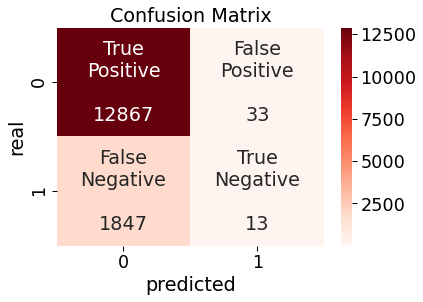


accuracy_score:		 0.873
f1_score:		 0.0136
recall_score:		 0.00699
MSE:			 0.127
roc_auc_score:		 0.656



In [35]:
lr = LogisticRegression()
visualise_metrics(lr, X, y)


Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



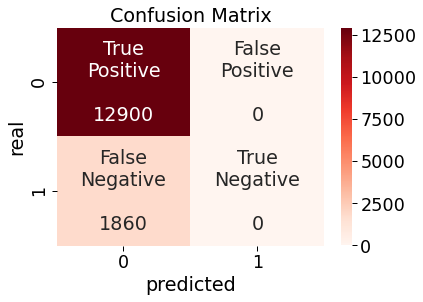


accuracy_score:		 0.874
f1_score:		 0.0
recall_score:		 0.0
MSE:			 0.126
roc_auc_score:		 0.558



In [36]:
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

+ Наивная модель готова выдавать кредит всем подряд, а class_weight='balanced' почему-то не только не исправляет ситуацию, но и приводит к ещё более плохому значению оценки ROC AUC... 

# 4. Вторичная обработка данных

Попробуем дополнительно поработать над всеми признаками.

In [37]:
# посмотрим, можно ли получить полезный признак из app_date

score['weekday'] = pd.to_datetime(score.app_date).apply(lambda x: x.weekday())
score.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,weekday
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,...,50,1,2,18000,4,1,0,0,1,5
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,...,50,2,3,19000,4,1,0,0,1,2
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,...,80,1,2,30000,1,4,1,0,1,5
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,...,50,2,3,10000,1,3,0,0,1,3
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,...,60,2,3,30000,1,4,1,0,1,4


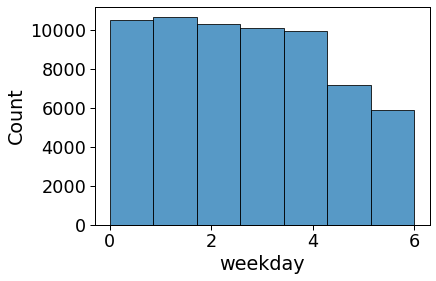

In [38]:
sns.histplot(x='weekday', data=score[score['default'] == 0], bins=7)

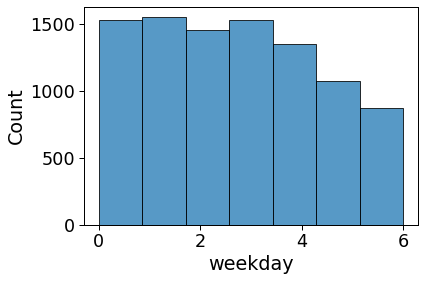

In [39]:
sns.histplot(x='weekday', data=score[score['default'] == 1], bins=7)

+ Похоже, что распределение заявок по дням недели не коррелирует с дефолтом, так что этот признак модели не поможет.

In [40]:
score['app_date'] = pd.to_datetime(score['app_date'], format='%d%b%Y')
date_min = min(score['app_date'])
score['days'] = (score['app_date'] - date_min).dt.days.astype('int')
score.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,weekday,days
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,...,1,2,18000,4,1,0,0,1,5,31
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,...,2,3,19000,4,1,0,0,1,2,70
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,...,1,2,30000,1,4,1,0,1,5,31
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,...,2,3,10000,1,3,0,0,1,3,22
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,...,2,3,30000,1,4,1,0,1,4,107


In [41]:
# оставим числовой признак days, а weekday и app_date уберём
score.drop(['weekday', 'app_date'],  axis=1, inplace=True)

In [42]:
num_cols.append('days')

In [43]:
# и перезаменим пропуски в education на наиболее распространённое значение
score.education.replace('UNK', 'SCH', inplace=True)

In [44]:
# проанализируем выбросы
for column in num_cols:
    median = score[column].median()
    IQR = score[column].quantile(0.75) - score[column].quantile(0.25)
    perc25 = score[column].quantile(0.25)
    perc75 = score[column].quantile(0.75)

    print("Column: ", column)
    print("Максимальное значение в данных:", score[column].max())
    print("Минимальное значение в данных:", score[column].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "1.5*IQR range: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  1.5*IQR range: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  1.5*IQR range: [0.0, 0.0].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  1.5*IQR range: [-3.299251946250001, -0.5290698762499992].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  1.5*IQR range: [-4.5, 7.5].

Column:  region_rating
Максимальное значение в данных: 80
Минимальное значение в данных: 20
25%: 50.0, 75%: 60.0, IQR: 10.0,  1.5*IQR range: [35.0, 75.0].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  1.5*IQR range: [-22000.

+ Значительные выбросы в признаках income, bki_request_cnt и decline_app_cnt. Возможно помогло бы категоризовать эти переменные, разбив на несколько основных классов.

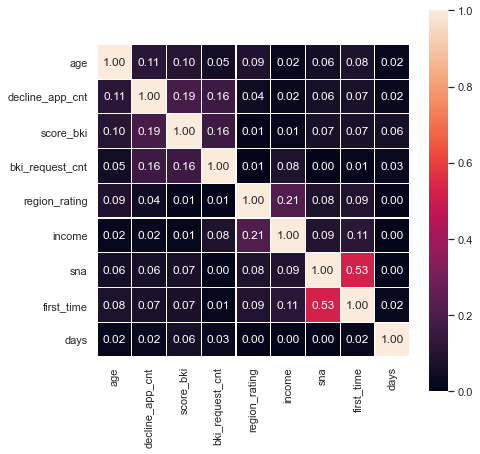

In [45]:
# Посмотрим матрицу коэффициента корреляции численных признаком
sns.set(font_scale=1)
fig, axis = plt.subplots(figsize=(7, 7))
sns.heatmap(score[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
            annot=True, fmt=".2f", linewidths=0.1)

+ Признаки друг с другом коррелируют слабо, так что нет смысла убирать какие-нибудь из них на этом основании.

# 5. Анализ значимости признаков

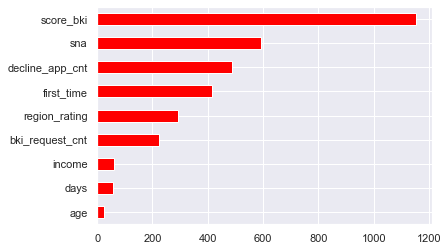

In [46]:
imp_num = pd.Series(f_classif(score[num_cols], score['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', color='red')

In [47]:
score['education'] = LabelEncoder().fit_transform(score['education'])

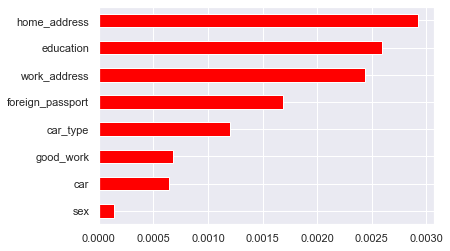

In [49]:
imp_cat = pd.Series(mutual_info_classif(score[bin_cols + cat_cols], score['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', color='red')

+ score_bki, sna, home_address, education и work_address - основные значимые признаки.

In [50]:
# Преобразуем категориальные признаки с помощью get_dummies
score = pd.get_dummies(score, columns=cat_cols)

In [51]:
score.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,education_1,education_2,education_3,education_4,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3
0,25905,1,62,1,1,0,0,-2.008753,1,50,...,0,0,1,0,1,0,0,0,1,0
1,63161,0,59,0,0,0,0,-1.532276,3,50,...,0,0,1,0,0,1,0,0,0,1
2,25887,1,25,1,0,2,0,-1.408142,1,80,...,0,0,1,0,1,0,0,0,1,0
3,16222,0,53,0,0,0,0,-2.057471,2,50,...,0,0,1,0,0,1,0,0,0,1
4,101655,1,48,0,0,0,1,-1.244723,1,60,...,1,0,0,0,0,1,0,0,0,1


In [52]:
# выполним стандартизацию численных переменных
score[num_cols] = pd.DataFrame(
    StandardScaler().fit_transform(score[num_cols]), columns=num_cols)

# 6. Логистическая регрессия

In [53]:
train_processed = score.query('sample == 1').drop(['sample'], axis=1)
test_processed = score.query('sample == 0').drop(['sample'], axis=1)

In [54]:
# удалим для X целевую переменную и client_id
X = train_processed.drop(columns=['default', 'client_id'])
y = train_processed['default']


Model Type: LogisticRegression(max_iter=1000, random_state=31)



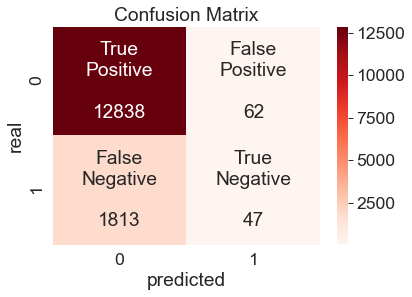


accuracy_score:		 0.873
f1_score:		 0.0477
recall_score:		 0.0253
MSE:			 0.127
roc_auc_score:		 0.733



In [55]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)


Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



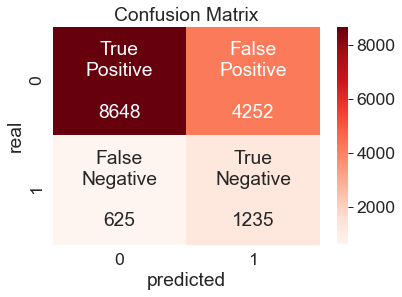


accuracy_score:		 0.67
f1_score:		 0.336
recall_score:		 0.664
MSE:			 0.33
roc_auc_score:		 0.733



In [56]:
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

+ После подготовки признаков модели логарифмической прогрессии получились сильно лучше в смысле оценки ROC AUC. В сбалансированной модели резко уменьшается количество ошибок первого рода, но появляется значительное количество ошибок второго рода.

# 7. Подбор гиперпараметров

In [57]:
# создадим набор гиперпараметров
hyperparameters = {'C': np.logspace(0, 4, 20)}

X = train_processed.drop(columns=['default', 'client_id'])
y = train_processed['default']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=RANDOM_SEED, test_size=0.2)

model = LogisticRegression(random_state=RANDOM_SEED,
                           class_weight='balanced', max_iter=1000)

# создадим сетку поиска с использованием 5-кратной перекрёстной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='roc_auc')

In [58]:
best_model = clf.fit(X_train, y_train)

# вывод лучшего параметра С
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее C: 1.0



Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



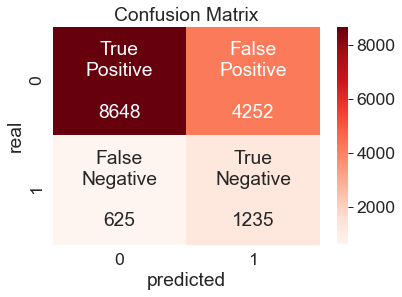


accuracy_score:		 0.67
f1_score:		 0.336
recall_score:		 0.664
MSE:			 0.33
roc_auc_score:		 0.733



In [59]:
lr_best = LogisticRegression(
    random_state=RANDOM_SEED, class_weight='balanced', max_iter=1000, C=1.0)
visualise_metrics(lr_best, X, y)

+ Подбор гиперпараметров при помощи GridSearchCV показал, что значение по умолчанию (С==1.0) и есть самое лучшее.


Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



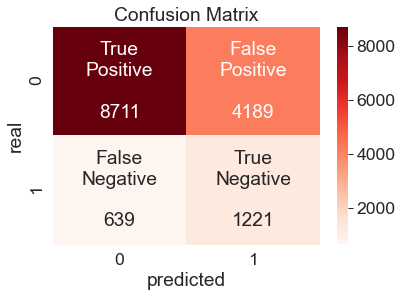


accuracy_score:		 0.673
f1_score:		 0.336
recall_score:		 0.656
MSE:			 0.327
roc_auc_score:		 0.729



In [60]:
# проверим также, нет ли смысла выкинуть из рассмотрения данные, наименее значимые согласно f_classif и mutual_info_classif
X = train_processed.drop(columns=['default', 'client_id', 'sex', 'age'])
y = train_processed['default']
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

+ sex и age были ранее определены как наименее значимые признаки, но стандартная логистическая модель без них даёт более плохой результат, чем с ними.

# 8. Прочие модели


Model Type: LogisticRegression(max_iter=1000)



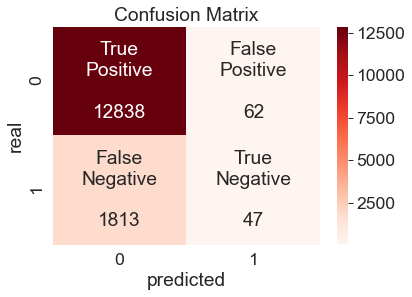


accuracy_score:		 0.873
f1_score:		 0.0477
recall_score:		 0.0253
MSE:			 0.127
roc_auc_score:		 0.733

----------------------

Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



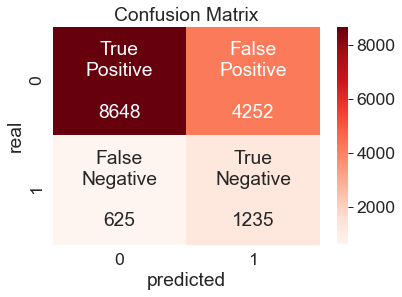


accuracy_score:		 0.67
f1_score:		 0.336
recall_score:		 0.664
MSE:			 0.33
roc_auc_score:		 0.733

----------------------

Model Type: DecisionTreeClassifier()



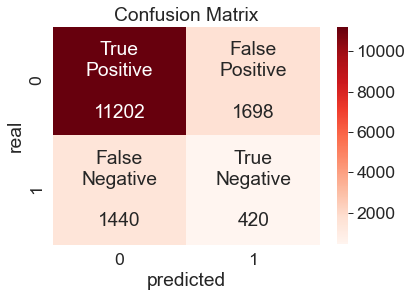


accuracy_score:		 0.787
f1_score:		 0.211
recall_score:		 0.226
MSE:			 0.213
roc_auc_score:		 0.547

----------------------

Model Type: ExtraTreeClassifier()



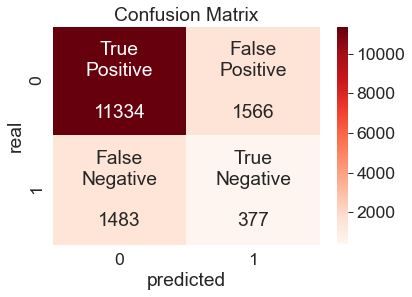


accuracy_score:		 0.793
f1_score:		 0.198
recall_score:		 0.203
MSE:			 0.207
roc_auc_score:		 0.541

----------------------

Model Type: AdaBoostClassifier()



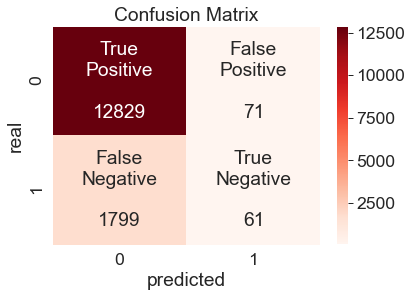


accuracy_score:		 0.873
f1_score:		 0.0612
recall_score:		 0.0328
MSE:			 0.127
roc_auc_score:		 0.734

----------------------

Model Type: BaggingClassifier()



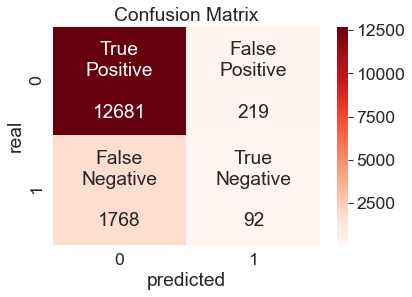


accuracy_score:		 0.865
f1_score:		 0.0848
recall_score:		 0.0495
MSE:			 0.135
roc_auc_score:		 0.65

----------------------

Model Type: ExtraTreesClassifier()



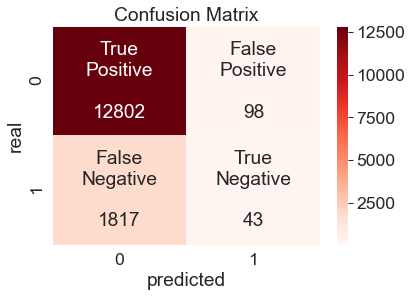


accuracy_score:		 0.87
f1_score:		 0.043
recall_score:		 0.0231
MSE:			 0.13
roc_auc_score:		 0.69

----------------------

Model Type: GradientBoostingClassifier()



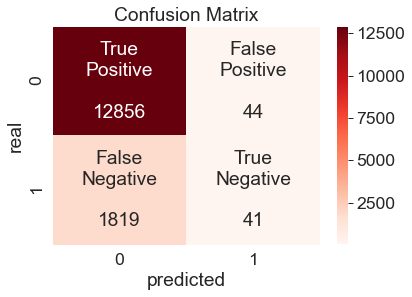


accuracy_score:		 0.874
f1_score:		 0.0422
recall_score:		 0.022
MSE:			 0.126
roc_auc_score:		 0.736

----------------------

Model Type: RandomForestClassifier()



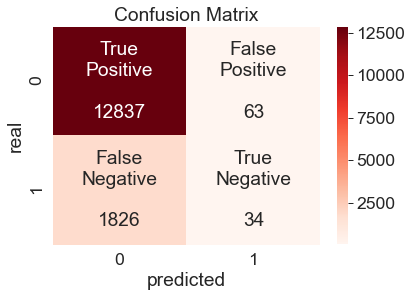


accuracy_score:		 0.872
f1_score:		 0.0347
recall_score:		 0.0183
MSE:			 0.128
roc_auc_score:		 0.706

----------------------

Model Type: <catboost.core.CatBoostClassifier object at 0x000001D3C1CB3670>



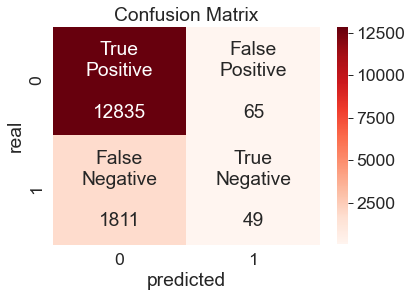


accuracy_score:		 0.873
f1_score:		 0.0496
recall_score:		 0.0263
MSE:			 0.127
roc_auc_score:		 0.735

----------------------


In [61]:
# проверим работу целого набора стандартных моделей на обработанных данных

X = train_processed.drop(columns=['default', 'client_id'])
y = train_processed['default']

test_all_models(X, y)

+ Почти аналогичные результаты результатам логистической регрессии показывают AdaBoostClassifier, GradientBoostingClassifier и CatBoostClassifier. Хотя у всех идентичные проблемы с True Negative.


Model Type: LogisticRegression(max_iter=1000)



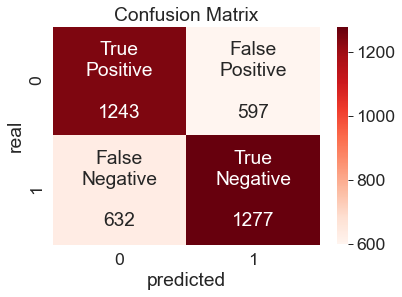


accuracy_score:		 0.672
f1_score:		 0.675
recall_score:		 0.669
MSE:			 0.328
roc_auc_score:		 0.734

----------------------

Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=31)



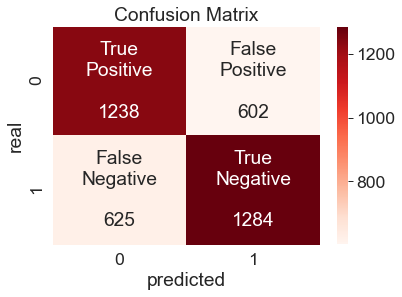


accuracy_score:		 0.673
f1_score:		 0.677
recall_score:		 0.673
MSE:			 0.327
roc_auc_score:		 0.734

----------------------

Model Type: DecisionTreeClassifier()



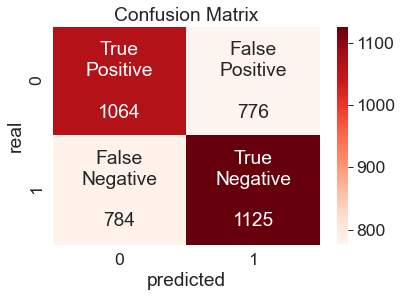


accuracy_score:		 0.584
f1_score:		 0.591
recall_score:		 0.589
MSE:			 0.416
roc_auc_score:		 0.584

----------------------

Model Type: ExtraTreeClassifier()



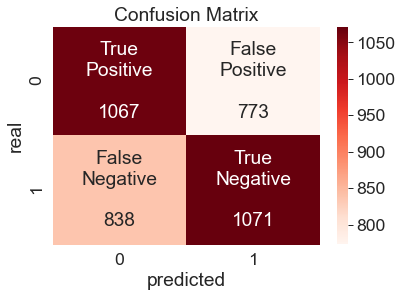


accuracy_score:		 0.57
f1_score:		 0.571
recall_score:		 0.561
MSE:			 0.43
roc_auc_score:		 0.57

----------------------

Model Type: AdaBoostClassifier()



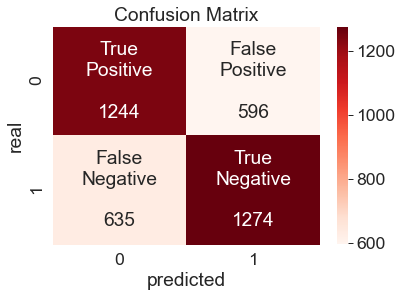


accuracy_score:		 0.672
f1_score:		 0.674
recall_score:		 0.667
MSE:			 0.328
roc_auc_score:		 0.73

----------------------

Model Type: BaggingClassifier()



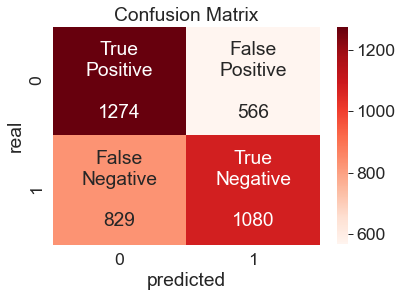


accuracy_score:		 0.628
f1_score:		 0.608
recall_score:		 0.566
MSE:			 0.372
roc_auc_score:		 0.669

----------------------

Model Type: ExtraTreesClassifier()



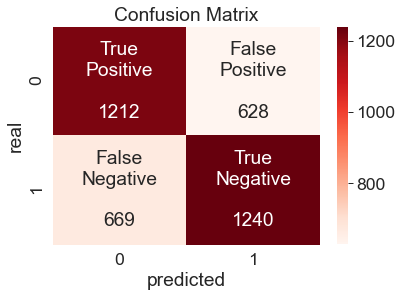


accuracy_score:		 0.654
f1_score:		 0.657
recall_score:		 0.65
MSE:			 0.346
roc_auc_score:		 0.7

----------------------

Model Type: GradientBoostingClassifier()



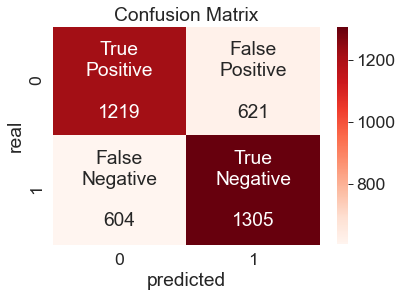


accuracy_score:		 0.673
f1_score:		 0.681
recall_score:		 0.684
MSE:			 0.327
roc_auc_score:		 0.735

----------------------

Model Type: RandomForestClassifier()



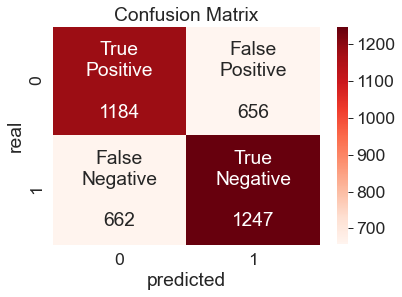


accuracy_score:		 0.648
f1_score:		 0.654
recall_score:		 0.653
MSE:			 0.352
roc_auc_score:		 0.71

----------------------

Model Type: <catboost.core.CatBoostClassifier object at 0x000001D3C6D7B580>



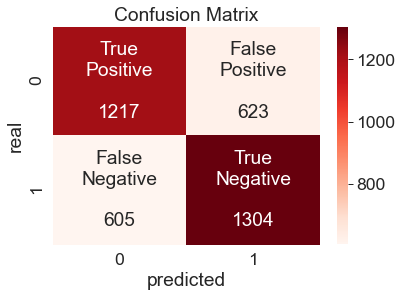


accuracy_score:		 0.672
f1_score:		 0.68
recall_score:		 0.683
MSE:			 0.328
roc_auc_score:		 0.734

----------------------


In [62]:
# попробуем также использовать undersampling,
# чтобы проверить разные модели на сбалансированной выборке:

# оставим случайным образом в тренировочных данных столько строк с нулевым дефолтом,
# сколько всего есть данных меньшего класса
train_unders = pd.concat([train_processed[train_processed['default'] == 0].sample(
    len(train_processed[train_processed['default'] == 1]), random_state=RANDOM_SEED),
    train_processed[train_processed['default'] == 1]])

X = train_unders.drop(columns=['default', 'client_id'])
y = train_unders['default']

test_all_models(X, y)

+ На сбалансированных данных все модели ожидаемо улучшают предсказания по дефолтным клиентам, лучше всего (с ROC AUC == 0.735) отрабатывает GradientBoostingClassifier.

# Submission

In [63]:
# подготавливаем данные из тестовой выборки
X_test = test_processed.drop(columns=['default', 'client_id'])

# обучаем логистическую регрессию с лучшими гиперпараметрами и на всём множестве сбалансированных данных из train
lr_balanced = LogisticRegression(
    random_state=RANDOM_SEED, class_weight='balanced', max_iter=1000, C=1.0)

X = train_unders.drop(columns=['default', 'client_id'])
y = train_unders['default']

lr_balanced.fit(X, y)

# итоговый файл на основе модели логистической регрессии с class_weight='balanced' и C=1.0
probs = lr_balanced.predict_proba(X_test)[:, 1]
result_lrb = pd.DataFrame(data={'client_id':test['client_id'], 'default':probs})
result_lrb.to_csv('submission_lrb.csv', index=False)
result_lrb

,client_id,default
0,74835,0.213158
1,17527,0.809552
2,75683,0.307204
3,26883,0.420921
4,28862,0.167355
...,...,...
36344,83775,0.759692
36345,106254,0.102019
36346,81852,0.757676
36347,1971,0.648232


In [64]:
grad_boost = GradientBoostingClassifier()

X = train_unders.drop(columns=['default', 'client_id'])
y = train_unders['default']

grad_boost.fit(X, y)

# итоговый файл на основе модели GradientBoostingClassifier, обученной на сбалансированных данных
probs = grad_boost.predict_proba(X_test)[:, 1]
result_gradb = pd.DataFrame(data={'client_id':test['client_id'], 'default':probs})
result_gradb.to_csv('submission_gradb.csv', index=False)
result_gradb

,client_id,default
0,74835,0.219936
1,17527,0.658788
2,75683,0.380917
3,26883,0.354704
4,28862,0.123398
...,...,...
36344,83775,0.791500
36345,106254,0.157666
36346,81852,0.701288
36347,1971,0.734296
